## Import Required Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import pandas as pd
import tensorflow as tf
import re
import nltk
import cv2
import pytesseract
from pytesseract import Output
import missingno as msno
from sklearn.utils import resample
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline    
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from matplotlib.colors import ListedColormap
from sklearn.metrics import precision_score, recall_score, plot_confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential

## Load Dataset

In [3]:
df = pd.read_csv("Datasets/spam_text.csv")
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Dataset Info

In [4]:
df.shape

(7977, 2)

In [5]:
df.columns

Index(['Category', 'Message'], dtype='object')

In [6]:
df.dtypes

Category    object
Message     object
dtype: object

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7977 entries, 0 to 7976
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  7977 non-null   object
 1   Message   7977 non-null   object
dtypes: object(2)
memory usage: 124.8+ KB


In [30]:
df.describe()

,Category,Message
count,7977,7977
unique,2,6644
top,ham,Welcome to Premier Pharmacy! Men's health depr...
freq,5344,110


## Checking for missing values in dataset

In [31]:
print(df.isnull().sum())

Category    0
Message     0
dtype: int64


<AxesSubplot:>

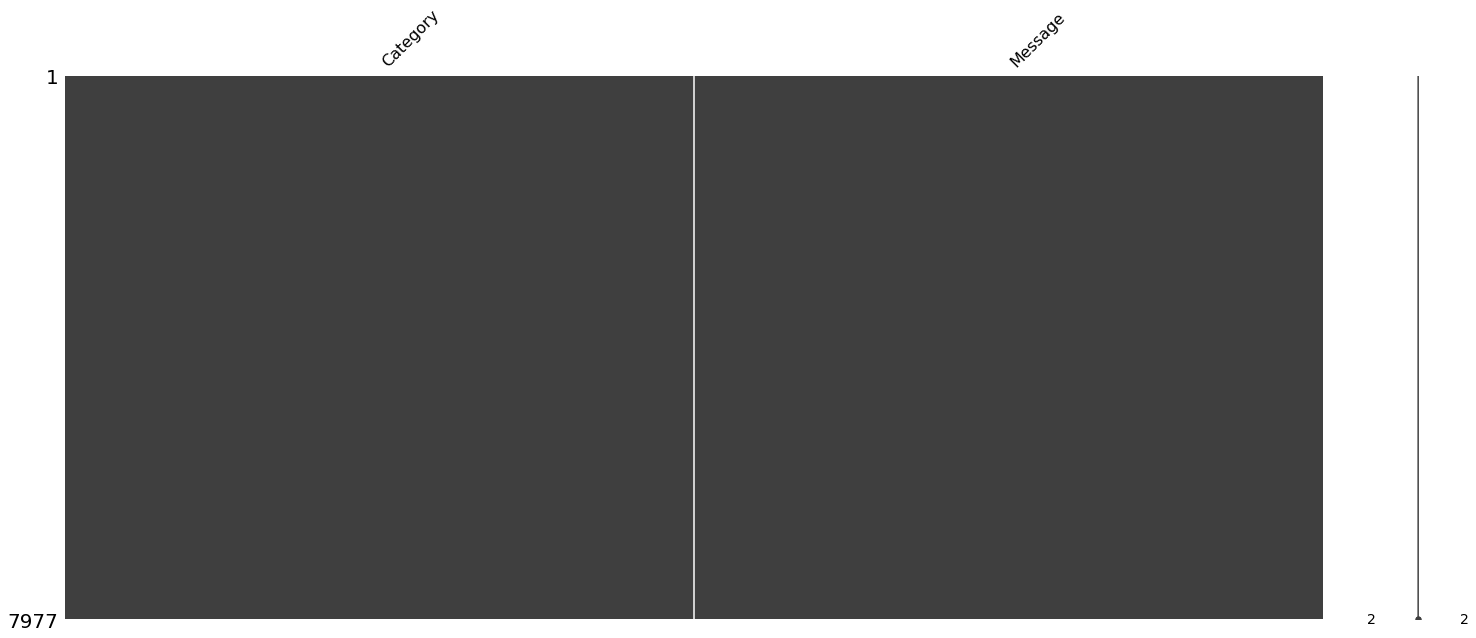

In [32]:
msno.matrix(df)

## Displaying count of spam and ham messages

In [33]:
# Unique values in target set
print("Unique values in the Target set: ", df.Category.unique())

Unique values in the Target set:  ['ham' 'spam']


In [34]:
balance_counts = df.groupby('Category')['Category'].agg('count').values
balance_counts

array([5344, 2633], dtype=int64)

In [35]:
len_spam=0
for i in range((df.shape[0])):
    if df['Category'][i]=="spam":
        len_spam+=1
print('The number of spam messages are: ', len_spam)

The number of spam messages are:  2633


In [36]:
len_ham=0
for i in range((df.shape[0])):
    if df['Category'][i]=="ham":
        len_ham+=1
print('The number of ham messages are: ', len_ham)

The number of ham messages are:  5344


## Plotting distribution of ham and spam messages in dataset

C:\Users\anshu\anaconda3\envs\tf2.8\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Number of ham and spam messages')

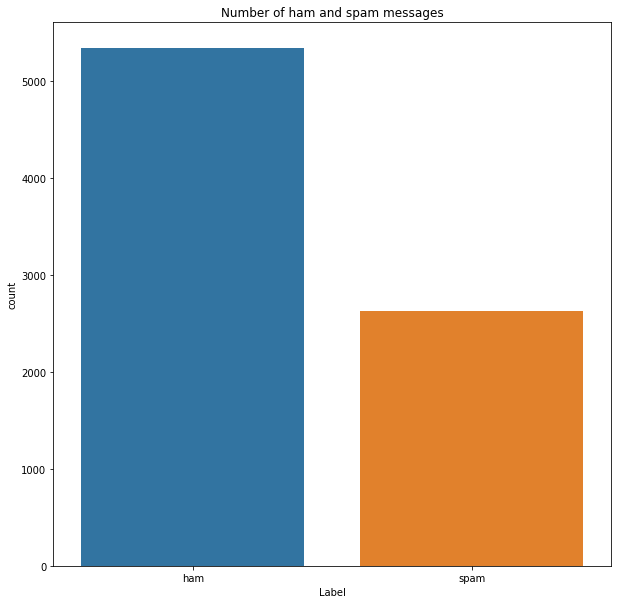

In [37]:
plt.figure(figsize=(10,10))
sns.countplot(df.Category)
plt.xlabel('Label')
plt.title('Number of ham and spam messages')

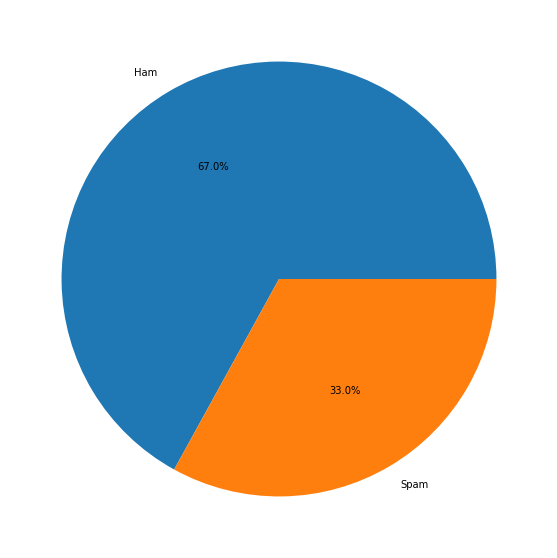

In [38]:
plt.figure(figsize=(10,10))
y = np.array([len_ham,len_spam])
mylabels = ["Ham", "Spam"]

plt.pie(y, labels = mylabels, autopct="%1.1f%%")
plt.show() 

## Performing Upsampling to eliminate class imbalance

In [8]:
#create two different dataframe of majority and minority class 
df_majority = df[(df['Category']=="ham")] 
df_minority = df[(df['Category']=="spam")] 
# upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,    # sample with replacement
                                 n_samples= 5344, # to match majority class
                                 random_state=42)  # reproducible results
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_minority_upsampled, df_majority])

In [9]:
df_upsampled.head()

,Category,Message
5685,spam,Want to buy MUST-HAVE drugs and save upto 85%?
6119,spam,SHYM Projects Over 24.2 Miliion In Sales For 2...
5955,spam,INVESTOR. ALERT ISSUED ON QCPC FOR JAN 30th!
5920,spam,Hydrocodone ‘Ambien Levitra Cialis Sanax Soma ...
6463,spam,Government Makes ECS150 Project Top Priority G...


In [10]:
df_upsampled.shape

(10688, 2)

In [11]:
balance_counts = df_upsampled.groupby('Category')['Category'].agg('count').values
balance_counts

array([5344, 5344], dtype=int64)

C:\Users\anshu\anaconda3\envs\tf2.8\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Number of ham and spam messages')

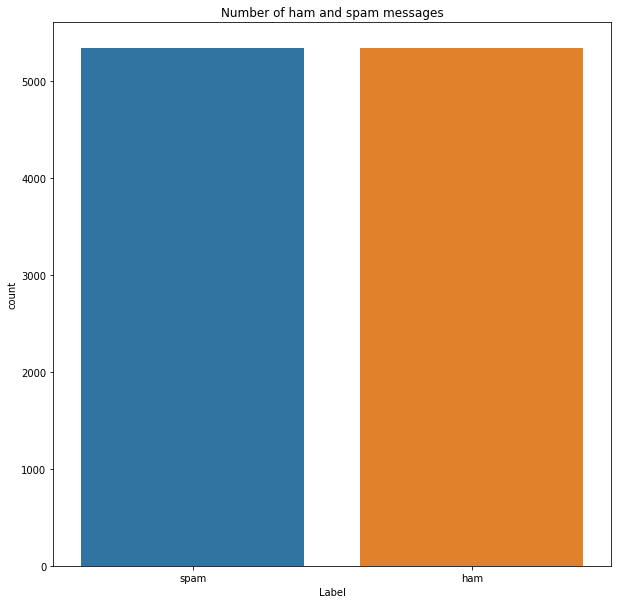

In [43]:
plt.figure(figsize=(10,10))
sns.countplot(df_upsampled['Category'])
plt.xlabel('Label')
plt.title('Number of ham and spam messages')

In [44]:
df = df_upsampled

In [51]:
df.head()

,Category,Message
0,spam,Want to buy MUST-HAVE drugs and save upto 85%?
1,spam,SHYM Projects Over 24.2 Miliion In Sales For 2...
2,spam,INVESTOR. ALERT ISSUED ON QCPC FOR JAN 30th!
3,spam,Hydrocodone ‘Ambien Levitra Cialis Sanax Soma ...
4,spam,Government Makes ECS150 Project Top Priority G...


In [52]:
df.shape

(10688, 2)

## Data Pre-processing

In [ ]:
def remove_html_tags(text):
    """Remove html tags from a string"""
    import re
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

In [53]:
# Defining a function to clean up the text
def Clean(Text):
    
    mail = Text.lower()
    
    mail = re.sub(r'http\S+', 'HTTP adds', mail)
    
    mail = re.sub('([A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,})',"emailed",mail)
    
    mail = re.sub(r'[0-9]+', 'number', mail)
    
    mail = re.sub(r'[$]', 'dollar', mail)
    
    mail = remove_html_tags(mail)
    
    mail = remove_stopwords(mail)
    return mail

In [54]:
def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    filtered_text = [word for word in text if word not in stop_words]
    return filtered_text

In [68]:
lemmatizer = WordNetLemmatizer()
# lemmatize string
def lemmatize_word(text):
    #word_tokens = word_tokenize(text)
    # provide context i.e. part-of-speech
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in text]
    return lemmas

In [56]:
df["Message"] = df["Message"].apply(Clean)
df.head()

,Category,Message
0,spam,want to buy must have drugs and save upto
1,spam,shym projects over miliion in sales for southe...
2,spam,investor alert issued on qcpc for jan th
3,spam,hydrocodone ambien levitra cialis sanax soma
4,spam,government makes ecs project top priority gnd ...


In [57]:
df["Message"]=df.apply(lambda row: nltk.word_tokenize(row["Message"]), axis=1)
df.head()

,Category,Message
0,spam,"[want, to, buy, must, have, drugs, and, save, ..."
1,spam,"[shym, projects, over, miliion, in, sales, for..."
2,spam,"[investor, alert, issued, on, qcpc, for, jan, th]"
3,spam,"[hydrocodone, ambien, levitra, cialis, sanax, ..."
4,spam,"[government, makes, ecs, project, top, priorit..."


In [58]:
df["Message"] = df["Message"].apply(remove_stopwords)
df.head()

,Category,Message
0,spam,"[want, buy, must, drugs, save, upto]"
1,spam,"[shym, projects, miliion, sales, southern, hom..."
2,spam,"[investor, alert, issued, qcpc, jan, th]"
3,spam,"[hydrocodone, ambien, levitra, cialis, sanax, ..."
4,spam,"[government, makes, ecs, project, top, priorit..."


In [59]:
df["Message"] = df["Message"].apply(lemmatize_word)
df.head()

,Category,Message
0,spam,"[want, buy, must, drug, save, upto]"
1,spam,"[shym, project, miliion, sales, southern, home..."
2,spam,"[investor, alert, issue, qcpc, jan, th]"
3,spam,"[hydrocodone, ambien, levitra, cialis, sanax, ..."
4,spam,"[government, make, ecs, project, top, priority..."


In [60]:
encode = {"Category": {"spam": 1, "ham": 0}}
df = df.replace(encode)
df.head()

,Category,Message
0,1,"[want, buy, must, drug, save, upto]"
1,1,"[shym, project, miliion, sales, southern, home..."
2,1,"[investor, alert, issue, qcpc, jan, th]"
3,1,"[hydrocodone, ambien, levitra, cialis, sanax, ..."
4,1,"[government, make, ecs, project, top, priority..."


In [61]:
corpus= []
for i in df["Message"]:
    msg = ' '.join([row for row in i])
    corpus.append(msg)
    
corpus[:5]
print("The First 5 lines in corpus :",*corpus[:5], sep = "\n")

The First 5 lines in corpus :
want buy must drug save upto
shym project miliion sales southern home medical equipment inc symbol sh price company move recently acquire nev companiss sign letter intent two mors thay announce project sales million ons gon na rocket grab shim get great return
investor alert issue qcpc jan th
hydrocodone ambien levitra cialis sanax soma
government make ecs project top priority gnd backe government fund bralorne mine company symbol blnn price


## Vectorizing data

In [62]:
#Changing text data in to numbers. 
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(corpus).toarray()
#Let's have a look at our feature 
X.dtype

dtype('float64')

In [63]:
y=df['Category']
y

0        1
1        1
2        1
3        1
4        1
        ..
10683    0
10684    0
10685    0
10686    0
10687    0
Name: Category, Length: 10688, dtype: int64

## Defining model


Displaying results for 90% training and 10% testing distribution


The accuracy score obtained for the combination is: 99.15809167446211%



Classification Report

              precision    recall  f1-score   support

         Ham       0.99      0.99      0.99       562
        Spam       0.99      0.99      0.99       507

    accuracy                           0.99      1069
   macro avg       0.99      0.99      0.99      1069
weighted avg       0.99      0.99      0.99      1069



Confusion Matrix


C:\Users\anshu\anaconda3\envs\tf2.8\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


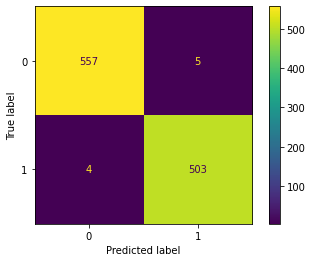

In [19]:
model = SVC(kernel='linear', probability = True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, train_size=0.9, random_state=0)
model.fit(X_train, y_train)
print(f'\nDisplaying results for 90% training and 10% testing distribution\n\n')
test_accuracy = model.score(X_test,y_test)
print(f'The accuracy score obtained for the combination is: {test_accuracy*100}%\n')
print('\n')
pred_test = model.predict(X_test)
print('Classification Report\n')
target_names = ['Ham','Spam']
print(classification_report(y_test, pred_test,target_names=target_names))
print('\n')
print('Confusion Matrix')


plot_confusion_matrix(model, X_test, y_test)

## Saving the model

In [64]:
filename = 'models/text_model_modified.sav'

In [23]:
pickle.dump(model, open(filename, 'wb'))